# GerryFair Tutorial

## Required Data Format

In order to train and audit for bias, we require three dataframes. The first two are the standard `X` and `Y`, which are the samples and their labels respectively. The third required dataframe is the list of protected attributes. This contains the values of the protected attributes for each row in the sample. These will be the attributes for which we will enforce fairness constraints (coupled with a function class over these attributes).

#### Cleaning Data
If your data is not in that format, it needs to be cleaned. We provide a method, `clean_data` in *clean.py*, you can use to clean your data into the accepted format.

The variable `dataset` should hold the file path to the file containing the dataset. The variable `attributes` should hold the file path to the file containing protected attributes. This should simply be one row where a column is 2 if it is the label, 1 if it is protected, and 0 otherwise. You should set `centered` to be `True` if you want the data to be centered. We provide several examples of correctly formatted files in the `dataset` folder.

In [1]:
import gerryfair
dataset = "./dataset/communities.csv"
attributes = "./dataset/communities_protected.csv"
centered = True
X, X_prime, y = gerryfair.clean.clean_dataset(dataset, attributes, centered)

label feature: ['ViolentCrimesPerPop']
sensitive features: ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctForeignBorn', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian']
there are 18 sensitive features including derivative features


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Using tools to train a model

Now, we can use the `Model` class in order to train a new model. When instatiating the object, you may provide any options that you will want when training the classifier. If you wish to change the options, you may use the `set_options` method. Both are shown below.

In [2]:
C = 15
printflag = True
gamma = .01
fair_model = gerryfair.model.Model(C=C, printflag=printflag, gamma=gamma, fairness_def='FP')
max_iters = 30
fair_model.set_options(max_iters=max_iters)

Now that we are happy with the options, we can use the `train` method to train a classifier using the Fictitious Play algorithm described in [the original paper](https://arxiv.org/abs/1711.05144v3). We will need our three dataframes from earlier. We also return the errors and fairness violations from each iteration of training.

We will first split `X` and `y` into a training and a testing set.

In [3]:
# Train Set
train_size = 500

X_train = X.iloc[:train_size]
X_prime_train = X_prime.iloc[:train_size]
y_train = y.iloc[:train_size]

# Test Set
X_test = X.iloc[train_size:].reset_index(drop=True)
X_prime_test = X_prime.iloc[train_size:].reset_index(drop=True)
y_test = y.iloc[train_size:].reset_index(drop=True)

# Train the model
[errors, fp_difference] = fair_model.train(X_train, X_prime_train, y_train)

iteration: 1
most accurate classifier error: 0.086, most accurate class unfairness: 0.013255813953488373, violated group size: 0.424
iteration: 2
error: 0.391, fairness violation: 0.006627906976744178, violated group size: 0.424
iteration: 3
error: 0.49, fairness violation: 0.004418604651162848, violated group size: 0.424
iteration: 4
error: 0.5395, fairness violation: 0.003313953488372089, violated group size: 0.424
iteration: 5
error: 0.5692, fairness violation: 0.002651162790697652, violated group size: 0.424
iteration: 6
error: 0.5833333333333334, fairness violation: 0.004143410852713174, violated group size: 0.36
iteration: 7
error: 0.5617142857142858, fairness violation: 0.009607973421927006, violated group size: 0.316
iteration: 8
error: 0.5255, fairness violation: 0.01725000000000001, violated group size: 0.406
iteration: 9
error: 0.4773333333333333, fairness violation: 0.016927002583979323, violated group size: 0.278
iteration: 10
error: 0.443, fairness violation: 0.0161174418

We can now use our model to make out of sample predictions. This can be done using the `predict` method of the object.

In [4]:
predictions = fair_model.predict(X_test)

## Using tools on evaluate a generic model

Once we have a model, whether it is fictitious play model or any generic model, we can use our tools to evaluate the fairness in several ways.

#### Auditing Predictions

You can audit for subgroup fairness of your predictions using the functionality within the `Auditor` object. These predictions can come from any arbitrary model. Auditing the predictions returns the group that failed the audit and gamma unfairness of the predictions on that group. We will be using our predictions from the previous part.

In [5]:
auditor = gerryfair.model.Auditor(X_prime_test, y_test, 'FP')
[violated_group, fairness_violation] = auditor.audit(predictions)
fairness_violation

0.013353005900515526

#### Plotting errors
You can also plot the errors of the model during training using the `plot_single` function in *fairness_plots.py*. Please note that these errors are returned by our fictitious play algorithm, so this is specifically for analyzing the effectiveness of our model.

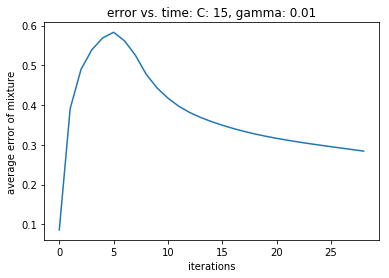

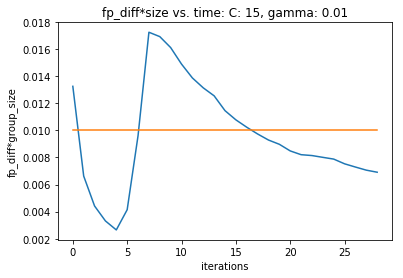

In [6]:
%matplotlib inline

gerryfair.fairness_plots.plot_single(errors, fp_difference, max_iters, gamma, C)